In [2]:
import os
import autogen
import autogen.runtime_logging
import pandas as pd
import sqlite3
import json
import docx
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from preprocessing.preprocessing import score_processor
from preprocessing.preprocessing import generate_conversations,process_pdf,rubric_processor
from multi_agent import subjective_agent,objective_agent,assessment_plan_agent
from general_SOAP_Note_agent import single_agent_generation,soapnoteagent
from evaluation_agent import evaluator_agent,score_generation,detail_score_generation
from refiner_agent import refiner_agent,refine_generation

Patching name='__init__', member=<function LLMLingua.__init__ at 0x000002787F9785E0>, patched=<function function.__call__ at 0x000002787F978540>
Patching name='compress_text', member=<function LLMLingua.compress_text at 0x000002787F978680>, patched=<function function.__call__ at 0x000002787F978860>


In [3]:
conversation_list,conversation_names=generate_conversations('C:/Users/rahul/Desktop/SOAPNote/dataset/VAT Patient Transcripts/VAT Patient Transcripts/')
MA_conversation_list=[i for i in conversation_list if ' M.A. User' in i]
RT_conversation_list=[i for i in conversation_list if 'R.T. User' in i or 'Patient R.T.’s Alexa' in i] 
RT_conversation_list=[i for i in RT_conversation_list if 'Baseline' not in i and 'Debrief' not in i  ]
rubric=rubric_processor('C:/Users/rahul/Desktop/SOAPNote/rubric/rubric.docx')
s_rubric=rubric.split('\nSubjective\n')[1].split('\nObjective\n')[0]
o_rubric=rubric.split('\nObjective\n')[1].split('\nAssessment\n')[0]
ap_rubric=rubric.split('\nAssessment\n')[1].split('\nIssues of Concern\n')[0]

In [4]:
from pypdf import PdfReader
MA_SOAP_NOTES_ground_truth=[]
path='C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/MA'

for i in os.listdir('C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/MA'):
    soap_note_ma=""
    file_name=path+'/'+i
    reader=PdfReader(file_name)
    if 'Week_1' not in file_name:
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            soap_note_ma+=text
    else:
        for j in range(1,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            soap_note_ma+=text
    MA_SOAP_NOTES_ground_truth.append(soap_note_ma)

RT_SOAP_NOTES=[]
file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/RT/Clinician - RT SOAP Notes.pdf"
reader=PdfReader(file_name)
for i in range(0,len(reader.pages)):
    soap_note_ra=""
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    soap_note_ra+=text
    RT_SOAP_NOTES.append(soap_note_ra)
RT_SOAP_NOTES=RT_SOAP_NOTES[:4]

In [5]:
len(RT_SOAP_NOTES)

4

In [6]:
len(MA_SOAP_NOTES_ground_truth)

5

In [7]:
from sklearn.model_selection import train_test_split
training_dict=dict()
for i in range(0,len(MA_conversation_list)):
    training_dict[MA_conversation_list[i]]=MA_SOAP_NOTES_ground_truth[i]

for i in range(0,len(RT_conversation_list)):
    training_dict[RT_conversation_list[i]]=RT_SOAP_NOTES[i]

X=list(training_dict.keys())
y=list(training_dict.values())
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

In [9]:
import textgrad as tg
from textgrad.tasks import load_task
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import sacrebleu
import os
from rouge_score import rouge_scorer
config_list = config_list_from_json("C:/Users/rahul/Documents/OAI_CONFIG_LIST.json")
api_key=config_list[0]['api_key']
os.environ["OPENAI_API_KEY"] = api_key
conversation=MA_conversation_list[0]
llm_engine = tg.get_engine("gpt-4o-mini")
tg.set_backward_engine("gpt-4o",override=True)

def batch_eval_fn(prediction,ground_truth):
    totalloss=None
    cross_entropy_loss_list=[]
    for pred,ans in zip(prediction,ground_truth):
        eval_system_prompt= f"""How closely does the generated SOAP note match this target SOAP note? Return a higher loss score for greater differences.

TARGET: {ans.value}

Score from 0-10 where:
- 0 = Perfect match
- 10 = Completely different"""
        cross_entropy_loss=tg.TextLoss(eval_system_prompt=eval_system_prompt,engine=llm_engine)
        cross_entropy_loss_list.append(cross_entropy_loss(pred))
    totalloss=tg.sum(cross_entropy_loss_list)
    return totalloss

question_str_list=[]
for i in X_train:
    question_str=f'''What would a comprehensive SOAP note look like based strictly on the 
    following conversation between a patient and a clinician: {i}, 
    ensuring it includes all relevant details from the conversation and follows the structure and style described in the provided rubric : {rubric}? '''
    question_str_list.append(tg.Variable(question_str,role_description="question to the LLM", requires_grad=False))
answer=[tg.Variable(i,role_description="answer to the question",requires_grad=False) for i in y_train]

system_prompt = tg.Variable(f"You are a clinician who is responsible for generating a SOAP Note from the conversation between the doctor(s) and the patient. Follow this rubric : {rubric}",
                            requires_grad=True,
                            role_description="system prompt to guide the LLM's reasoning strategy for accurate responses")


model = tg.BlackboxLLM(llm_engine, system_prompt=system_prompt)
optimizer = tg.TGD(parameters=list(model.parameters()))
prediction_list=[model(i) for i in question_str_list]
loss = batch_eval_fn(prediction_list,answer)
loss.backward()
optimizer.step()

In [10]:
system_prompt

Variable(value=You are a clinician responsible for generating a SOAP Note from the conversation between the doctor(s) and the patient. Your task is to capture the session's dynamics, focusing on the interactions, motivations, and roles of the participants. Follow this rubric:

Introduction:
The Subjective, Objective, Assessment, and Plan (SOAP) note is a structured method of documentation for healthcare providers. It provides a framework for clinical reasoning and communication among health professionals.

Function:
The SOAP note serves as a cognitive aid and a potential index for retrieving information for learning from the record.

Structure:
The 4 headings of a SOAP note are Subjective, Objective, Assessment, and Plan. Each heading is described below.

Subjective:
- Capture the patient's experiences, views, or feelings.
- Include specific goals and motivations expressed by the patient.
- Document the interaction dynamics, including support and prompting from caregivers.

Objective:


In [11]:
single_soap_note_list=[]
for conversation in X:
    soap_note=single_agent_generation(conversation,rubric,system_prompt.value)
    single_soap_note_list.append(soap_note)

In [12]:
single_soap_note_list

['**SOAP Note**\n\n**Subjective:**\nPatient M, a visually impaired individual, attended a session to practice commands with their Alexa device, mainly focusing on scheduling reminders and accessing entertainment. Patient M expressed contentment at independently setting reminders, showcasing excitement over successfully using the device. The caregiver, Speaker 3, played an active supportive role, helping to unmute Alexa and encouraging Patient M during the session. Patient M conveyed a preference for sports, particularly ice hockey, and auditory games designed for the visually impaired. Speaker 3 supported the patient by facilitating game setups and offering imaginative assistance, like drawing out sports plays. There was a notable emphasis on exploring entertainment options via technology, fostering independence and engagement.\n\n**Objective:**\nDuring the session, Patient M attempted several Alexa commands:\n- Successfully set an appointment for 5:45 PM. \n- Faced an initial challeng

In [13]:
for i in single_soap_note_list:
    print(i)

**SOAP Note**

**Subjective:**
Patient M, a visually impaired individual, attended a session to practice commands with their Alexa device, mainly focusing on scheduling reminders and accessing entertainment. Patient M expressed contentment at independently setting reminders, showcasing excitement over successfully using the device. The caregiver, Speaker 3, played an active supportive role, helping to unmute Alexa and encouraging Patient M during the session. Patient M conveyed a preference for sports, particularly ice hockey, and auditory games designed for the visually impaired. Speaker 3 supported the patient by facilitating game setups and offering imaginative assistance, like drawing out sports plays. There was a notable emphasis on exploring entertainment options via technology, fostering independence and engagement.

**Objective:**
During the session, Patient M attempted several Alexa commands:
- Successfully set an appointment for 5:45 PM. 
- Faced an initial challenge with Ale

In [14]:
import sacrebleu,rouge_score
bleu = sacrebleu.corpus_bleu(single_soap_note_list,[y])
bleu

BLEU = 3.77 39.4/7.0/2.4/1.1 (BP = 0.729 ratio = 0.760 hyp_len = 5394 ref_len = 7099)

In [15]:
from classifier_agents import multi_class_classification
from pypdf import PdfReader
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
demo_text=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    demo_text+=text
communication_instances=[]
for i in X:
    communication_instances.append(multi_class_classification(i,demo_text))


In [ ]:
from docx import Document
output_folder="C:/Users/rahul/Desktop/SOAPNote/SOAP_note_generation/gpt4o/communication breakdowns"
for i in range(len(classification_results)):
    doc=Document()
    doc.add_paragraph(classification_results[i])
    filename=f"{conversation_names[i]}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

In [16]:
from presence_agent import check_presence
single_agent_instance=[]
ground_instance=[]
for i in range(0,len(communication_instances)):
    ground_instance.append(check_presence(communication_instances[i],y[i]))
    single_agent_instance.append(check_presence(communication_instances[i],single_soap_note_list[i]))


In [17]:
ground_instance

['- Total instances found: 3\n- Details:\n  1. Interaction with Alexa: Scenarios using Alexa for scheduling and reminders were documented, including setting alarms and reminders for various tasks and events.\n  2. Interaction with Alexa: Group Training/Alexa command practice where the participant practiced 3 voice commands related to scheduling and reminders.\n  3. Communication breakdown: During the command practice, the participant needed verbal cueing to increase the loudness of his voice to accurately execute the voice command, and he did not provide details related to time and day for the reminder, prompting Alexa to ask follow-up questions.',
 "- Total instances found: 5\n- Details:\n  1. M.A. practiced a command to schedule appointments, indicating an interaction with Alexa.\n  2. M.A.'s mother mentioned that M.A. had set and shut off a timer independently, indicating a successful interaction with Alexa.\n  3. M.A. practiced 10 voice commands related to entertainment, indicating

In [18]:
single_agent_instance

['- Total instances found: 2\n- Details:\n  1. Faced an initial challenge with Alexa not hearing the command but succeeded on the second attempt. (Communication breakdown)\n  2. Successfully executed an Alexa command to play "Sweet Caroline," illustrating proficiency when commands were specific and concise. (Successful interaction with Alexa)',
 '- Total instances found: 1\n- Details: \n  - M.A. demonstrated the ability to successfully communicate commands to Speaker 4 for setting reminders, with a few repetitions needed for accuracy. This indicates a communication breakdown requiring multiple attempts for successful interaction.',
 '- Total instances found: 3\n- Details:\n  1. Interaction with Alexa: Successfully demonstrated setting reminders and organizing self-care schedules using Speaker 4.\n  2. Interaction with Alexa: Practiced voice commands for deleting items from a medication list, adding reminders for medication timing, and sourcing local pharmacies.\n  3. Communication brea

In [24]:
communication_instances
names=['MA-Week1','MA-Week2','MA-Week3','MA-Week4','MA-Week5','RA-Week1','RA-Week2','RA-Week3','RA-Week4']
from docx import Document
import os
output_folder="C:/Users/rahul/Desktop/SOAPNote/communication_instances"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(communication_instances)):
    doc=Document()
    doc.add_paragraph(communication_instances[i])
    filename=f"{names[i]}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week1.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week2.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week3.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week4.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week5.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week1.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week2.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week3.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week4.docx


In [20]:
import regex as re
count_list=[]
for i in communication_instances:
    matches=re.findall(re.escape("Instance"), i)
    count_list.append(len(matches))
count_list


[4, 5, 9, 11, 5, 0, 6, 6, 2]

In [22]:
import textgrad as tg
from textgrad.tasks import load_task
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import sacrebleu
import os
from rouge_score import rouge_scorer
config_list = config_list_from_json("C:/Users/rahul/Documents/OAI_CONFIG_LIST.json")
api_key=config_list[0]['api_key']
os.environ["OPENAI_API_KEY"] = api_key
conversation=MA_conversation_list[0]
llm_engine = tg.get_engine("gpt-4o-mini")
tg.set_backward_engine("gpt-4o",override=True)

def batch_eval_fn(prediction,ground_truth):
    totalloss=None
    cross_entropy_loss_list=[]
    for pred,ans in zip(prediction,ground_truth):
        eval_system_prompt= f"""How closely does the generated SOAP note match this target SOAP note? Return a higher loss score for greater differences.

TARGET: {ans.value}

Score from 0-10 where:
- 0 = Perfect match
- 10 = Completely different"""
        cross_entropy_loss=tg.TextLoss(eval_system_prompt=eval_system_prompt,engine=llm_engine)
        cross_entropy_loss_list.append(cross_entropy_loss(pred))
    totalloss=tg.sum(cross_entropy_loss_list)
    return totalloss

question_str_list=[]
for i in X:
    question_str=f'''What would a comprehensive SOAP note look like based strictly on the 
    following conversation between a patient and a clinician: {i}, 
    ensuring it includes all relevant details from the conversation and follows the structure and style described in the provided rubric : {rubric}? '''
    question_str_list.append(tg.Variable(question_str,role_description="question to the LLM", requires_grad=False))
answer=[tg.Variable(i,role_description="answer to the question",requires_grad=False) for i in y_train]

system_prompt = tg.Variable(f"You are a clinician who is responsible for generating a SOAP Note from the conversation between the doctor(s) and the patient. Follow this rubric : {rubric}",
                            requires_grad=True,
                            role_description="system prompt to guide the LLM's reasoning strategy for accurate responses")


model = tg.BlackboxLLM(llm_engine, system_prompt=system_prompt)
optimizer = tg.TGD(parameters=list(model.parameters()))
prediction_list=[model(i) for i in question_str_list]
loss = batch_eval_fn(prediction_list,answer)
loss.backward()
optimizer.step()

In [37]:
system_prompt.value

"You are a clinician responsible for generating a comprehensive SOAP Note from the conversation between the doctor(s) and the patient. Your goal is to accurately capture the patient's interaction with technology, specifically focusing on activities of daily living (ADLs) and information-seeking tasks. Follow this structured approach:\n\n1. **Broader ADL-Related Tasks**: Emphasize a wide range of ADL-related tasks beyond just recipe and shopping list management. Include examples such as setting timers, playing music, managing reminders, and other daily activities to ensure a comprehensive view of the patient's functional activities.\n\n2. **Motivational Assessment**: Assess and document the patient's motivation and readiness to engage with the device. Evaluate the patient's enthusiasm, willingness to learn, and any motivational factors influencing their interaction with the device.\n\n3. **Performance Metrics**: Incorporate quantitative performance metrics in the SOAP note. Track succes

In [24]:
single_soap_note_list_1=[]
for conversation in X:
    soap_note=single_agent_generation(conversation,rubric,system_prompt.value)
    single_soap_note_list_1.append(soap_note)

In [25]:
import sacrebleu,rouge_score
bleu = sacrebleu.corpus_bleu(single_soap_note_list_1,[y])
bleu

BLEU = 2.92 35.2/5.5/1.3/0.5 (BP = 0.858 ratio = 0.867 hyp_len = 6158 ref_len = 7099)

In [26]:
from presence_agent import check_presence
single_agent_instance_1=[]
for i in range(0,len(communication_instances)):
    single_agent_instance_1.append(check_presence(communication_instances[i],single_soap_note_list_1[i]))

In [27]:
single_agent_instance_1

['- Total instances found: 2\n- Details:\n  1. Successfully set up reminders and a class appointment with Alexa. (Successful interaction)\n  2. Attempted and partially succeeded in playing music through voice commands; faced limitations with music library access. (Technology-related communication issue)',
 '- Total instances found: 2\n- Details:\n  1. Successfully set appointments and reminders using Speaker 4.\n  2. Positive engagement and prompt learning ability demonstrated by engaging with Speaker 4 for varied commands.',
 '- Total instances found: 1\n- Details: \n  - Difficulty encountered in syncing certain applications like the Bard app with the device for reading books.',
 '- Total instances found: 1\n- Details: \n  - Verbal interaction with Alexa shows understanding but requires occasional prompts to correct and retry commands.',
 '- Total instances found: 1\n- Details: \n  - Continued difficulties with getting complete verbal interaction through voice command, especially with

In [29]:
pattern=r"Total instances found:\s*(\d+)"
single_score=[]
single_score_1=[]
ground_score=[]
for i in range(len(communication_instances)):
    single_match=re.search(pattern,single_agent_instance[i])
    single_match_1=re.search(pattern,single_agent_instance_1[i])
    ground_match=re.search(pattern,ground_instance[i])
    single_score.append(int(single_match.group(1)))
    single_score_1.append(int(single_match_1.group(1)))
    ground_score.append(int(ground_match.group(1)))


In [32]:
ground_score

[3, 5, 3, 2, 2, 2, 2, 2, 1]

In [36]:
sum(ground_score)/sum(count_list)

0.4583333333333333

In [42]:
score_list=[single_score[i]/count_list[i] if count_list[i]!=0 else 0 for i in range(0,len(ground_score))]
ground_score_list=[ground_score[i]/count_list[i] if count_list[i]!=0 else 0 for i in range(0,len(ground_score))]
score_list_1=[single_score_1[i]/count_list[i] if count_list[i]!=0 else 0 for i in range(0,len(ground_score))]

In [1]:
MA_single_score=score_list[:5]
RT_single_score=score_list[5:9]
MA_ground_score=ground_score_list[:5]
RT_ground_score=ground_score_list[5:9]
MA_single_score_1=score_list_1[:5]
RT_single_score_1=score_list_1[5:9]
print(sum(RT_single_score_1)/len(RT_single_score_1))

NameError: name 'score_list' is not defined

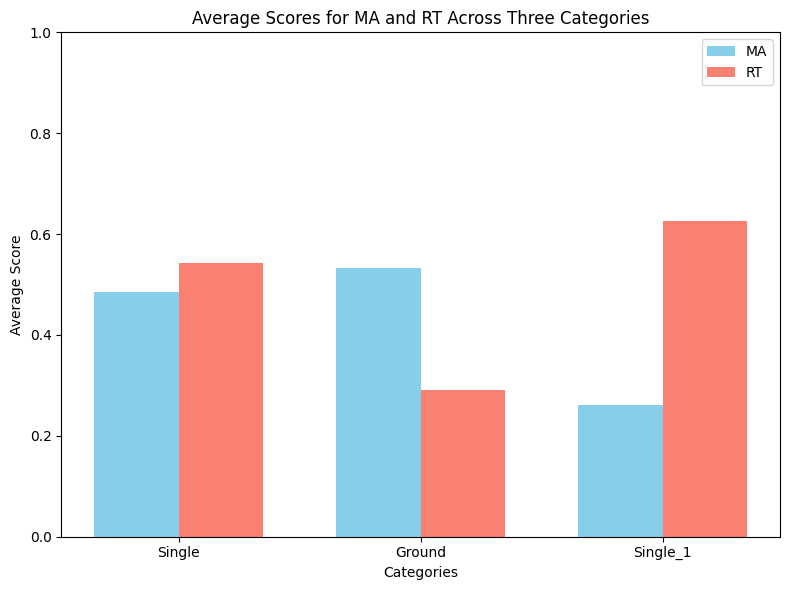

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Category labels
labels = ['Single', 'Ground', 'Single_1']

# Average scores for MA and RT for each category
MA_averages = [0.4849494949494949,0.533030303030303 , 0.2604040404040404]
RT_averages = [0.5416666666666666,0.29166666666666663 , 0.625]

x = np.arange(len(labels))
width = 0.35  # Width of each bar

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, MA_averages, width, label='MA', color='skyblue')
plt.bar(x + width/2, RT_averages, width, label='RT', color='salmon')

plt.xlabel('Categories')
plt.ylabel('Average Score')
plt.title('Average Scores for MA and RT Across Three Categories')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()